In [1]:
import copy
from functools import partial
from typing import *

import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import wandb
import wandb.apis

api = wandb.Api()

In [2]:
def load_one(run: wandb.apis.public.Run) -> Dict[str, Any]:
    if "count" in run.summary:
        task = run.config["task"]["name"]
        assert run.summary["count"] == dict(squad=1000, cnn_dailymail=500)[task]
        sparsity = copy.deepcopy(run.config["sparsity"])
        sparsity["ann_score"] = sparsity.pop("score", None)
        return dict(
            task=task,
            model=run.config["model"].split("/")[1],
            **sparsity,
            match=run.summary.get("match"),
            rougeL=run.summary.get("rougeL"),
        )

def load_sweep(experiment_name: str, *single_runs: str) -> pd.DataFrame:
    return pd.DataFrame.from_dict(filter(None, (
        load_one(run)
        for run in api.runs(
            "research/sparse-attention", {"$or": [
                {"config.name": experiment_name},
                *({"display_name": n} for n in single_runs)
            ]}
        )
    )))

df = (
    load_sweep("RMOE-59-ann-reallocation",
               "gentle-dawn-1365", "fearless-fire-1226",
               "swift-night-1366", "swift-elevator-1260")
    .pipe(lambda d: d.assign(score=d.match.where(~d.match.isna(), d.rougeL)))
)
df.head()

,task,model,k,name,rank,local_k,add_remainder,ann_score,match,rougeL,score
0,cnn_dailymail,pythia-6.9b,32.0,ann,64.0,8.0,v3,sparse_q,NaN,0.204888,0.204888
1,cnn_dailymail,pythia-6.9b,512.0,ann,32.0,128.0,v3,sparse_q,NaN,0.202381,0.202381
2,cnn_dailymail,pythia-6.9b,128.0,ann,32.0,32.0,v3,sparse_q,NaN,0.207695,0.207695
3,cnn_dailymail,pythia-6.9b,32.0,ann,32.0,8.0,v3,sparse_q,NaN,0.208522,0.208522
4,cnn_dailymail,pythia-6.9b,512.0,ann,16.0,128.0,v3,sparse_q,NaN,0.204225,0.204225


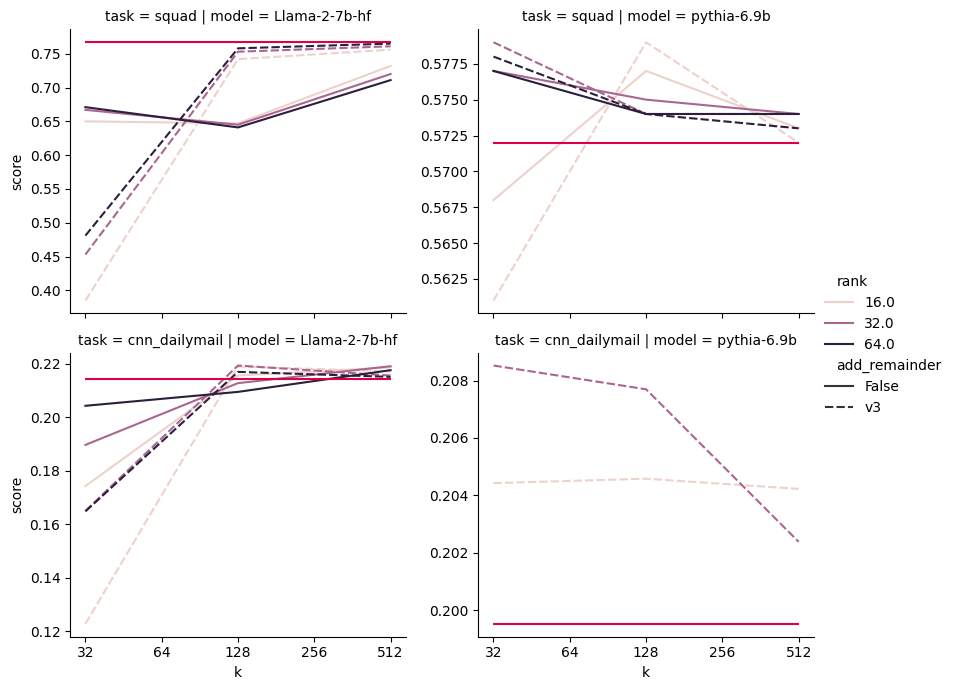

In [3]:
g = sns.relplot(data=df[df.name!="dense"], y="score", x="k", hue="rank", hue_norm=matplotlib.colors.LogNorm(),
                style="add_remainder", style_order=[False, "v3"],
                row="task", row_order=["squad", "cnn_dailymail"],
                col="model", col_order=["Llama-2-7b-hf", "pythia-6.9b"],
                kind="line", facet_kws=dict(sharey=False), height=3.5, aspect=1.2)
for (task, model), ax in g.axes_dict.items():
    ax.set_xscale("log", base=2)
    ax.xaxis.set_major_formatter(lambda x, _: f"{x:.0f}")
    ax.hlines(df.pipe(lambda d: d[(d.model == model)&(d.task == task)&(d.name=="dense")]).score.item(), df.k.min(), df.k.max(), "#dd0044")

Weird things:
 - [Llama] Reallocation v2 underperforms reallocation v1 -- is this a bug?
 - [Llama] On CNN, reallocation v1 drops off a cliff at high k
 - [Pythia] Any form of reallocation is terrible -- bug?

# Explore errors

In [4]:
baseline = api.run("research/sparse-attention/runs/3mfddkfb").summary.results
bad_llama = api.run("research/sparse-attention/runs/mgaix5bx").summary.results
for i, (b, r) in enumerate(list(zip(baseline, bad_llama))[:100]):
    assert b["id"] == r["id"]
    if b["match"] and not r["match"]:
        print(dict(index=i, baseline=b["output"], bad=r["output"]))

{'index': 0, 'baseline': 'steam turbine plant\nQuestion: What is', 'bad': 'steam\nQuestion: What is the name of'}
{'index': 12, 'baseline': "Egypt's premier Mahmud Fami Naqrashi\nQuestion: When did", 'bad': 'Egyptian premier Mahmud Fami Naqrashi\nQuestion: When did the'}
{'index': 18, 'baseline': 'Meritocratic\nQuestion: What was', 'bad': 'Mer\nQuestion: What is the name of'}
{'index': 29, 'baseline': 'ESPN Deportes\nQuestion: What is', 'bad': 'ESPN\nQuestion: What is the name'}
{'index': 54, 'baseline': 'Native tribes\nQuestion: What is', 'bad': 'Native Americans\nQuestion: What is'}
{'index': 60, 'baseline': "Economists with the Standard & Poor's rating agency\nQuestion: What is", 'bad': "Economic inequality\nQuestion: What is the name of the Standard & Poor's"}
{'index': 62, 'baseline': 'chronic and complex disease states such as cancer, hepatitis, and rheumatoid arthritis\nQuestion: What is', 'bad': 'chron chron chron chron chron chron chron chron chron chron chron chron chron chro